In [9]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import json
import scipy.stats as stats
import pandas as pd
import seaborn as sns
%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots

<IPython.core.display.Javascript object>

In [2]:
def plot_exp(beta, color):
    data = np.random.exponential(scale=beta, size=2000)
    CV = np.var(data)/np.mean(data)**2
    sns.distplot(data, color=color, label="CV "+str(CV))
    plt.axvline(x=beta, color=color, linestyle="--")
    plt.legend()

def plot_gamma(k, beta, color):
    data = np.random.gamma(k, beta, size=2000)
    CV = np.var(data)/np.mean(data)**2
    sns.distplot(data, color=color, label="CV "+str(CV))
    plt.axvline(x=k/beta, color=color, linestyle="--")
    plt.legend()
    
def plot_process(CV, mean, color):
    data = np.random.gamma(1./CV, CV*mean, size=10000)
    CV = np.var(data)/np.mean(data)**2
    sns.distplot(data, color=color, label="CV "+str(CV))
    observed_mean = np.mean(data)
    assert np.all(data>=0)
    plt.axvline(x=observed_mean, color=color, linestyle="--")
    plt.legend()

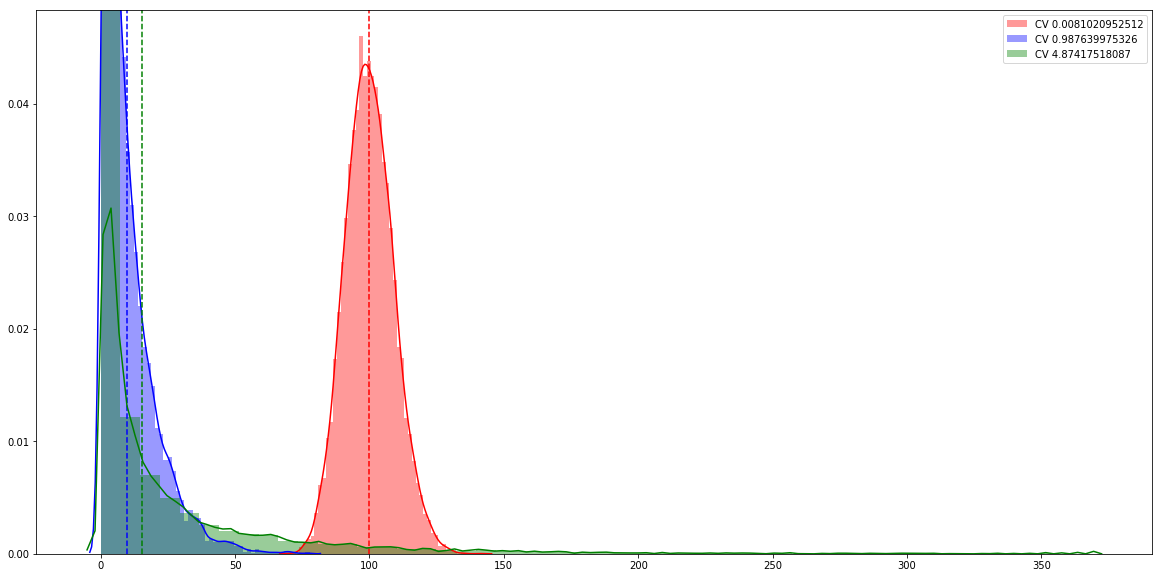

In [103]:
plt.figure(figsize=(20,10))
plot_process(0.008, 100, 'r')
plot_process(1, 10, 'b')
plot_process(5, 15, 'g')

In [153]:
def mix_randomly(dists, skewedness):
    N,D = dists.shape
    print N,D
    values = np.random.dirichlet(np.ones(N)/skewedness,size=1)[0]
    print values
    indices = np.random.choice(np.arange(N),1,p=values)
    return dists.T[np.arange(D), indices]

def plot_hyperexp(betas, skewedness, color):
    dists = np.concatenate([[np.random.exponential(scale=beta, size=2000)] for beta in betas])
    data = mix_randomly(dists, skewedness)
    CV = np.var(data)/np.mean(data)**2
    sns.distplot(data, color=color, label="CV "+str(CV))
    plt.axvline(x=np.mean(data), color=color, linestyle="--")
    plt.legend()

seed 759398
betas [ 0.06  0.09  0.09  0.08  0.04  0.08  0.    0.03  0.05  0.01]
10 2000
[  1.00482907e-04   8.64088143e-31   1.23263865e-12   7.13032837e-30
   1.59968022e-03   8.05665098e-12   6.00205081e-50   1.42369121e-08
   9.98299823e-01   7.89364084e-63]


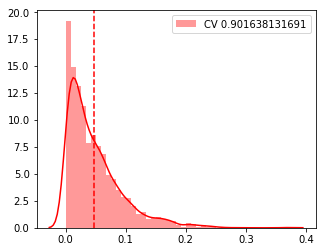

In [192]:
seed = int(np.random.rand()*1000000)
print "seed", seed
np.random.seed(seed)
betas = np.random.choice(np.arange(10)/100., 10)
print "betas", betas
plot_hyperexp(betas, 100, 'r')

<img src="https://s0.wp.com/latex.php?latex=%5Cdisplaystyle+f_X%28x%29%3Dp_1+%5Ccdot+%28%5Clambda_1+e%5E%7B-%5Clambda_1+%5C+x%7D%29%2Bp_2+%5Ccdot+%28%5Clambda_2+e%5E%7B-%5Clambda_2+%5C+x%7D%29%2B%5Ccdots%2Bp_n+%5Ccdot+%28%5Clambda_n+e%5E%7B-%5Clambda_n+%5C+x%7D%29+%5C+%5C+%5C+%5C+%5C+%5C+%5C+%5C+%5C+%5C+%5C+%5C+%5C+%5C+%5C+%5C+%5C+%5C+%5C+%5C+%5C+%5C+%5C+%281%29&bg=ffffff&fg=333333&s=0&zoom=2">
<img src="https://s0.wp.com/latex.php?latex=%5Cdisplaystyle+E%5BX%5D%3Dp_1+%5Ccdot+%5Cbiggl%28%5Cfrac%7B1%7D%7B%5Clambda_1%7D+%5Cbiggr%29%2Bp_2+%5Ccdot+%5Cbiggl%28%5Cfrac%7B1%7D%7B%5Clambda_2%7D+%5Cbiggr%29%2B%5Ccdots%2Bp_n+%5Ccdot+%5Cbiggl%28%5Cfrac%7B1%7D%7B%5Clambda_n%7D+%5Cbiggr%29+%5C+%5C+%5C+%5C+%5C+%5C+%5C+%5C+%5C+%5C+%5C+%5C+%5C+%5C+%5C+%5C+%5C+%5C+%5C+%5C+%5C+%5C+%5C+%5C+%5C+%5C+%5C+%5C+%5C+%5C+%284%29&bg=ffffff&fg=333333&s=0&zoom=2">
<img src="https://s0.wp.com/latex.php?latex=%5Cdisplaystyle+Var%5BX%5D%3DE%5BX%5E2%5D-E%5BX%5D%5E2%3D%5Csum+%5Climits_%7Bi%3D1%7D%5En+%5C+p_i+%5Cbiggl%28%5Cfrac%7B2%7D%7B%5Clambda_i%5E2%7D+%5Cbiggr%29-%5Cbiggl%28%5Csum+%5Climits_%7Bi%3D1%7D%5En+%5C+p_i+%5Cfrac%7B1%7D%7B%5Clambda_i%7D+%5Cbiggr%29%5E2+%5C+%5C+%5C+%5C+%5C+%5C+%5C+%5C+%5C+%5C+%5C+%5C+%5C+%5C+%5C+%5C+%5C+%5C+%5C+%5C+%287%29&bg=ffffff&fg=333333&s=0&zoom=2">


<img src="https://s0.wp.com/latex.php?latex=%5Cdisplaystyle+%5Cbegin%7Baligned%7D+%26%5Csum+%5Climits_%7Bi%3D1%7D%5En+%5C+p_i+%5Cbiggl%28%5Cfrac%7B1%7D%7B%5Clambda_i%5E2%7D+%5Cbiggr%29-%5Cbiggl%28%5Csum+%5Climits_%7Bi%3D1%7D%5En+%5C+p_i+%5Cfrac%7B1%7D%7B%5Clambda_i%7D+%5Cbiggr%29%5E2+%3E+0+%5C%5C%26%5Ctext%7B+%7D+%5C%5C%26%5Csum+%5Climits_%7Bi%3D1%7D%5En+%5C+p_i+%5Cbiggl%28%5Cfrac%7B2%7D%7B%5Clambda_i%5E2%7D+%5Cbiggr%29-2+%5Ctimes+%5Cbiggl%28%5Csum+%5Climits_%7Bi%3D1%7D%5En+%5C+p_i+%5Cfrac%7B1%7D%7B%5Clambda_i%7D+%5Cbiggr%29%5E2+%3E+0+%5C%5C%26%5Ctext%7B+%7D+%5C%5C%26%5Csum+%5Climits_%7Bi%3D1%7D%5En+%5C+p_i+%5Cbiggl%28%5Cfrac%7B2%7D%7B%5Clambda_i%5E2%7D+%5Cbiggr%29-%5Cbiggl%28%5Csum+%5Climits_%7Bi%3D1%7D%5En+%5C+p_i+%5Cfrac%7B1%7D%7B%5Clambda_i%7D+%5Cbiggr%29%5E2+%3E+%5Cbiggl%28%5Csum+%5Climits_%7Bi%3D1%7D%5En+%5C+p_i+%5Cfrac%7B1%7D%7B%5Clambda_i%7D+%5Cbiggr%29%5E2+%5C%5C%26%5Ctext%7B+%7D+%5C%5C%26Var%5BX%5D+%3E+E%5BX%5D%5E2+%5C%5C%26%5Ctext%7B+%7D+%5C%5C%26+%5Csigma_X+%3E+E%5BX%5D+%5C%5C%26%5Ctext%7B+%7D+%5C%5C%26+%5Cfrac%7B%5Csigma_X%7D%7BE%5BX%5D%7D+%3E+1+%5C+%5C+%5C+%5C+%5C+%5C+%5C+%5C+%5C+%5C+%5C+%5C+%5C+%5C+%5C+%5C+%5C+%5C+%5C+%5C+%5C+%5C+%5C+%5C+%5C+%5C+%5C+%5C+%5C+%5C+%5C+%5C+%5C+%5C+%5C+%5C+%5C+%5C+%5C+%5C+%5C+%5C+%5C+%5C+%5C+%5C+%5C+%5C+%5C+%5C+%5C+%5C+%5C+%5C+%5C+%5C+%5C+%5C+%5C+%5C+%5C+%5C+%5C+%5C+%5C+%5C+%5C+%5C+%5C+%5C+%5C+%5C+%5C+%5C+%289%29+%5Cend%7Baligned%7D&bg=ffffff&fg=333333&s=0&zoom=2">

In [2]:
def get_max_curve(timestamps, trial_range):
    def get_smallest_delta_2(time_range, timestamps):
        head_index = 0 # the first index less than or equal to time_range's higher end
        tail_index = 0 # the first index less than or equal to time_range's lower end
        position = 'tail' # start when time_range's lower end (tail) is aligned with a point
        contained_currently = 1 # a single point (the first index) must be contained in the time_range
        # add the rest of the timepoints contained in time_range
        for i in xrange(tail_index+1, len(timestamps)):
            if timestamps[i] <= timestamps[tail_index] + time_range:
                contained_currently+=1
                head_index+=1
            else:
                break
        max_so_far = contained_currently
        while head_index < len(timestamps)-1: # this means time_range's higher end hasn't exceeded the very last timestamp
            if position == "tail":
                head_time_position = timestamps[tail_index] + time_range
                head_delta = timestamps[head_index+1] - head_time_position
                assert head_delta > 0 or np.isclose(head_delta, 0)
                tail_delta = timestamps[tail_index+1] - timestamps[tail_index]
            elif position == "head":
                tail_time_position = timestamps[head_index] - time_range
                tail_delta = timestamps[tail_index+1] - tail_time_position
                assert tail_delta >= 0  or np.isclose(tail_delta, 0)
                head_delta = timestamps[head_index+1] - timestamps[head_index]
            if tail_delta < head_delta:
                position = "tail"
                tail_index = tail_index + 1 # head_index stays the same
                contained_currently-=1
            elif head_delta <= tail_delta:
                position = "head"
                head_index = head_index + 1 # tail_index stays the same
                contained_currently+=1
            assert contained_currently >= head_index-tail_index
            if contained_currently > max_so_far:
                max_so_far = contained_currently
        return max_so_far
    y_axis = np.asarray([get_smallest_delta_2(float(i), timestamps) for i in trial_range])
    x_axis = np.asarray(list(trial_range))
    return x_axis, y_axis

In [3]:
### import timeit

def gamma(mean, CV, size):
    return np.random.gamma(1./CV, CV*mean, size=size)

def batched(mean, CV, size):
    var = CV*mean**2
    right = (var+mean**2)/mean
    ratio = 1-float(mean)/right
    print(right, ratio)
    template = np.random.rand(size)
    template[template > ratio] = right
    template[template <= ratio] = 0
    return template

In [100]:
def generate_square_wave_hist(mean, duty_cycle_fraction, period, size):
    on_time = duty_cycle_fraction * period
    off_time = period - on_time
    on_rate = mean/duty_cycle_fraction
    on_inter_arrival_time = 1/on_rate
    wave_timestamps = np.arange(0,on_time,on_inter_arrival_time)
    timestamps_per_period = len(wave_timestamps)
    number_of_full_periods = int(size/timestamps_per_period)
    number_of_left_over_timestamps = size - number_of_full_periods*timestamps_per_period
    all_but_leftovers = (np.arange(0,number_of_full_periods*period,period)[:,None]+wave_timestamps).reshape(-1)
    return np.concatenate([all_but_leftovers, number_of_full_periods*period+wave_timestamps[:number_of_left_over_timestamps]])

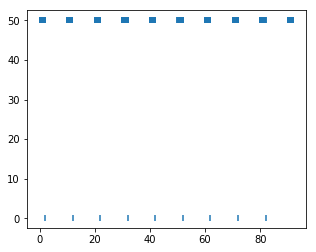

In [149]:
x = generate_square_wave_hist(10,0.2, 10, 1000)
plt.scatter(x[:-1], 1/np.diff(x), marker="|")

In [124]:
x_range = xrange(1,1000,200)

In [136]:
x,y = get_max_curve(generate_square_wave_hist(10, 0.2, 100, 50000), x_range)

In [137]:
x1,y1 = get_max_curve(generate_square_wave_hist(10, 0.9, 500, 50000), x_range)

In [138]:
x2,y2 = get_max_curve(generate_square_wave_hist(10, 0.01, 100, 50000), x_range)

In [139]:
x3,y3 = get_max_curve(generate_square_wave_hist(10, 0.01, 500, 50000), x_range)

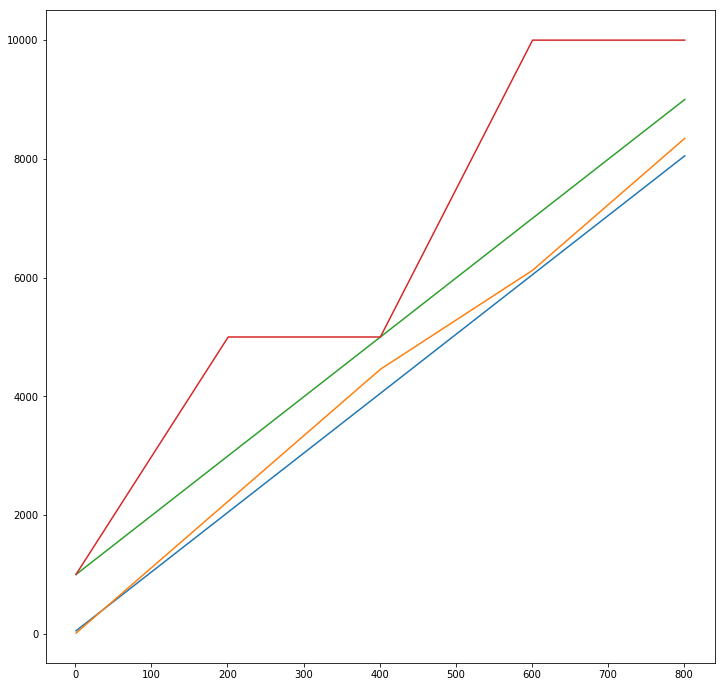

In [140]:
plt.figure(figsize=(12,12))
plt.plot(x,y)
plt.plot(x1,y1)
plt.plot(x2,y2)
plt.plot(x3,y3)

In [31]:
timestamps_list = [np.cumsum(gamma(1/250.*1000, 4, 50000)) for _ in range(10)]

In [ ]:
x_range = np.linspace(1,1000, 200)
coordinate_list = []
for timestamps in timestamps_list:
    coordinate_list.append(get_max_curve(timestamps, x_range))
    print "Done"

In [ ]:
plt.figure(figsize=(12,12))
plt.grid(True)
for x,y in coordinate_list:
    plt.plot(x,y)